In [ ]:
# ECGR 4106 HW5
# Author: Lucas Therrien
# Student ID #801122089
# GitHub Link: https://github.com/lucastherrien/ECGR4106HW5



##_________________________________________##
## Setup
##_________________________________________##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nbconvert
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer 
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.svm import SVC, SVR
import seaborn as sns
from matplotlib.colors import ListedColormap
import torch.nn as nn
import torch
import torch.utils.data.dataloader as dataloader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchmetrics import Accuracy
from torch import optim
from torchsummary import summary
import d2l.torch as d2l
import collections
import math
from torch.nn import functional as F
#Suppress all warnings because they annoy me
import warnings
warnings.filterwarnings("ignore")

In [ ]:
##_________________________________________##
## Problem 1
##_________________________________________##

In [45]:
def init_seq2seq(module):  #@save
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder-decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l * mask).sum() / mask.sum()

@d2l.add_to_class(d2l.EncoderDecoder)  #@save
def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
    batch = [a.to(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tgt[:, 0].unsqueeze(1), ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights

def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

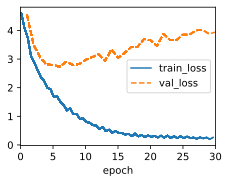

In [17]:
#1a
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 512, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
embed_size, num_hiddens, num_layers, dropout = 256, 512, 2, 0.2
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [18]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .','the resistance .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .','la résistance .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['elle', 'ici', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000
the resistance . => ['les', '<unk>', '<unk>', '.'], bleu,0.000


In [ ]:
# All attempts to impove the model above baseline failed

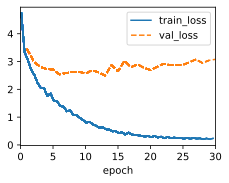

In [63]:
#1b
def init_seq2seq(module):  #@save
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        hidden_state = hidden_state[0:2]
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder-decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l * mask).sum() / mask.sum()

@d2l.add_to_class(d2l.EncoderDecoder)  #@save
def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
    batch = [a.to(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tgt[:, 0].unsqueeze(1), ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights

def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 3, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [64]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .','the resistance .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .','la résistance .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['sois', 'calme', '!'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000
the resistance . => ['les', '<unk>', '<unk>', '.'], bleu,0.000


In [ ]:
# The 3 encoded layer and 2 decoded layer setup did not seem to improve model performance

In [68]:
# 1c
def init_seq2seq(module):  #@save
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(input_size=embed_size+num_hiddens,hidden_size=num_hiddens,
                           num_layers=num_layers,dropout=dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(input_size=embed_size+num_hiddens,hidden_size=num_hiddens,
                           num_layers=num_layers,dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder-decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l * mask).sum() / mask.sum()

@d2l.add_to_class(d2l.EncoderDecoder)  #@save
def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
    batch = [a.to(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tgt[:, 0].unsqueeze(1), ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights

def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [69]:
data = d2l.MTFraEng(batch_size=128)

embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
#summary(model,input_size=(256,256))
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

RuntimeError: input.size(-1) must be equal to input_size. Expected 256, got 512

In [ ]:
##_________________________________________##
## Problem 2
##_________________________________________##

In [47]:
class AttentionDecoder(d2l.Decoder):  #@save
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state


class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights


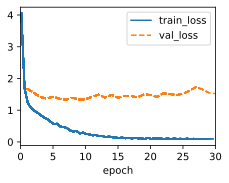

In [48]:
#2a 1 hidden layer
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 1, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [49]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .','the resistance .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .','la résistance .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['je', 'vais', 'bien', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000
the resistance . => ['les', '<unk>', '<unk>', '.'], bleu,0.000


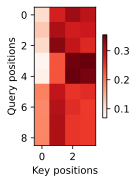

In [50]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

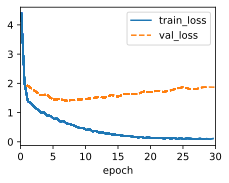

In [51]:
#2a 2 hidden layers
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [52]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .','the resistance .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .','la résistance .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['assieds-toi', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000
the resistance . => ['les', '<unk>', '<unk>', '.'], bleu,0.000


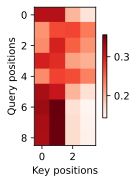

In [53]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

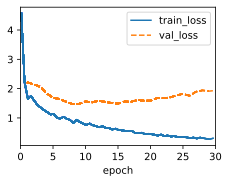

In [54]:
#2a 4 hidden layers
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 4, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [55]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .','the resistance .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .','la résistance .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'gagné', '.'], bleu,0.000
he's calm . => ['rentrez', 'chez', 'la', 'maison', '.'], bleu,0.000
i'm home . => ['je', 'suis', '<unk>', '.'], bleu,0.512
the resistance . => ['<unk>', '.'], bleu,0.000


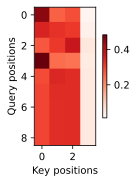

In [44]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

In [ ]:
# The model did worse the more hidden layers were added.

In [58]:
#2b
class AttentionDecoder(d2l.Decoder):  #@save
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(input_size=embed_size+num_hiddens,hidden_size=num_hiddens,
                           num_layers=num_layers,dropout=dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state


class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [57]:
#2b
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

RuntimeError: For batched 3-D input, hx and cx should also be 3-D but got (2-D, 2-D) tensors